In [1]:
import sys
sys.path.append('..')
import os
os.chdir('..')
import torch
import torchaudio
import os.path
from arg_extractor import extract_args_from_json
from experiment_builder import VQVAEExperimentBuilder
from model_architectures import VQVAE
from vctk_preprocessor import read_audio
import librosa.display
import matplotlib.pyplot as plt

In [2]:
args = extract_args_from_json('experiment_configs/vqvae_data20k_lr1e-6.json')
args.continue_from_epoch = 0
args.eval_speaker_id = 3
args.eval_out_path='audio_out'

args.eval_audio_path = 'data/VCTK-Corpus/wav48/p265/p265_075.wav'

In [3]:
# Load audio
audio_path = os.path.expanduser(args.eval_audio_path)
torchaudio.initialize_sox()
audio, sr = read_audio(audio_path, downsample=True, trim_silence=True)
torchaudio.shutdown_sox()
print(audio.shape)
audio = audio.unsqueeze(0)

torch.Size([1, 36925])


[-0.09838867 -0.03399658  0.10269165 ...  0.02957153  0.0262146
  0.02975464]


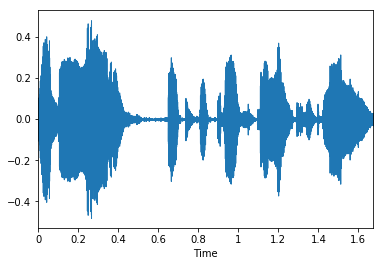

In [4]:
audio_plain = audio.numpy()[0, 0]
print(audio_plain)
plt.figure()
librosa.display.waveplot(audio_plain)

In [5]:
# Prepare speaker tensor
speaker_id = torch.tensor(args.eval_speaker_id, dtype=torch.long)

In [7]:
# Prepare model
vqvae_model = VQVAE(
    input_shape=(1, 1, args.input_max_len),
    encoder_arch=args.encoder,
    vq_arch=args.vq,
    generator_arch=args.generator,
    num_speakers=109)

# Load model from state
vqvae_experiment = VQVAEExperimentBuilder(network_model=vqvae_model,
                                    experiment_name=args.experiment_name,
                                    weight_decay_coefficient=args.weight_decay_coefficient,
                                    learning_rate=args.learning_rate,
                                    commit_coefficient=args.commit_coefficient,
                                    device=torch.device('cpu'),
                                    continue_from_epoch=-2,
                                    train_data=None,
                                    val_data=None,
                                    test_data=None,
                                    num_epochs=None)

Building VQVAE.
Building Encoder with 6 downsampling layers.
torch.Size([1, 1, 20000])
torch.Size([1, 16, 9999])
torch.Size([1, 32, 4998])
torch.Size([1, 64, 2498])
torch.Size([1, 128, 1248])
torch.Size([1, 128, 623])
torch.Size([1, 128, 310])
torch.Size([1, 64, 310])
Building VQ layer.
Building Decoder/Generator with 7 upsampling layers.
torch.Size([1, 64, 310])
torch.Size([1, 128, 602])
torch.Size([1, 128, 1185])
torch.Size([1, 128, 2361])
torch.Size([1, 64, 4749])
torch.Size([1, 32, 9487])
torch.Size([1, 16, 18977])
torch.Size([1, 1, 20000])
/home/vaidas/Projects/mlpcw/experiments/vqvae_data20k_lr1e-6 /home/vaidas/Projects/mlpcw/experiments/vqvae_data20k_lr1e-6/result_outputs
Loading model train_model, at epoch latest.


In [8]:
out = vqvae_experiment.convert(x=audio, y=speaker_id)[0].detach()

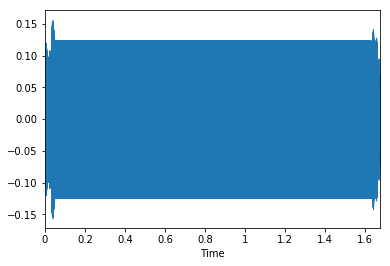

In [9]:
plt.figure()
librosa.display.waveplot(out[0].numpy())

In [10]:
out.shape

torch.Size([1, 36896])

In [10]:
out_path = os.path.expanduser(args.eval_out_path)
out_filename = '{}_{}.wav'.format(os.path.basename(args.eval_audio_path).split('.')[0], args.eval_speaker_id)
out_file_path = os.path.join(out_path, out_filename)

# Save as audio
torchaudio.save(filepath=out_file_path, src=out, sample_rate=sr)